## Import

In [5]:
import os 
import pandas as pd
import numpy as np
import ast
import re

# z test
from statsmodels.stats.proportion import proportions_ztest

# bayesian bootstrap and vis
import matplotlib.pyplot as plt
import seaborn as sns
import bayesian_bootstrap.bootstrap as bb
from astropy.utils import NumpyRNGContext

# progress bar
from tqdm import tqdm, tqdm_notebook

from scipy import stats
from collections import Counter

# set up the style for our plots
sns.set(style='white', palette='colorblind', font_scale=1.3,
        rc={'figure.figsize':(12,9), 
            "axes.facecolor": (0, 0, 0, 0)})

# instantiate progress bar goodness
tqdm.pandas(tqdm_notebook)

pd.set_option('max_colwidth',500)

# 10k, 5k crashed, try 4k
# also look to do a temp save of file at 6, in case of kernel crashing for bootstrap
boot_reps = 4000

## File/dir locations
### Processed journey data

In [6]:
DATA_DIR = os.getenv("DATA_DIR")
filename = "full_sample_taxon_ab_2019_947858.csv.gz"
filepath = os.path.join(
    DATA_DIR, "sampled_journey",
    filename)
filepath

'/Users/suganyasivaskantharajah/code/govuk_ab_analysis/data/sampled_journey/full_sample_taxon_ab_2019_947858.csv.gz'

In [7]:
# read in processed sampled journey with just the cols we need for related links
df = pd.read_csv(filepath, sep ="\t", compression="gzip")
# convert from str to list
df['Event_cat_act_agg']= df['Event_cat_act_agg'].progress_apply(ast.literal_eval)
df['Page_Event_List'] = df['Page_Event_List'].progress_apply(ast.literal_eval)
df['Page_List'] = df['Page_List'].progress_apply(ast.literal_eval)

100%|██████████| 748354/748354 [00:14<00:00, 50209.91it/s]


In [8]:
df['Page_List_Length'] = df['Page_List'].progress_apply(len)


100%|██████████| 748354/748354 [00:01<00:00, 737114.43it/s]


In [9]:
# drop dodgy rows, where page variant is not A or B. 
df = df.query('ABVariant in ["A", "B"]')

In [10]:
df.ABVariant.value_counts()

B    374217
A    374137
Name: ABVariant, dtype: int64

In [12]:
# how many occurrences (journeys) per variant
df.groupby('ABVariant').Occurrences.sum()

ABVariant
A    947859
B    947859
Name: Occurrences, dtype: int64

### Nav type of page lookup - is it a finding page? if not it's a thing page

In [13]:
filename = "document_types_20190214_20190218.csv.gz"

# created a metadata dir in the DATA_DIR to hold this data
filepath = os.path.join(
    DATA_DIR, "metadata",
    filename)
print(filepath)

df_finding_thing = pd.read_csv(filepath, sep="\t", compression="gzip")

df_finding_thing.head()

/Users/suganyasivaskantharajah/code/govuk_ab_analysis/data/metadata/document_types_20190214_20190218.csv.gz


,pagePath,is_finding
0,/exchange-foreign-driving-licence/y/yes/car-or-motorcycle/european-union,0
1,/dvlaforms,0
2,/licence-finder/activities?sectors=373_388,0
3,/carers-allowance/how-to-claim,0
4,/prepare-eu-exit,0


In [8]:
thing_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==0]['pagePath'].tolist()


finding_page_paths = df_finding_thing[
    df_finding_thing['is_finding']==1]['pagePath'].tolist()

## Outliers
Some rows should be removed before analysis. For example rows with journey lengths of 500 or very high related link click rates. This process might have to happen once features have been created.

## journey_click_rate
There is no difference in the proportion of journeys using at least one related link (journey_click_rate) between page variant A and page variant B.



\begin{equation*}
\frac{\text{total number of journeys including at least one click on a related link}}{\text{total number of journeys}}
\end{equation*}

### Prepare features

#### Related link prep

In [9]:
def get_number_of_events_rl(event):
    """Counts events with category 'relatedLinkClicked' and action'Related content'."""
    if event[0][0] == 'relatedLinkClicked' and 'Related content' in event[0][1]:
        return event[1]
    return 0


def sum_related_click_events(event_list):
    return sum([get_number_of_events_rl(event) for event in event_list])


def is_related(x):
    """Compute whether a journey includes at least one related link click."""
    return x > 0

In [10]:
# get the number of related links clicks per Sequence
df['Related Links Clicks per seq'] = df['Event_cat_act_agg'].map(sum_related_click_events)

In [11]:
# map across the Sequence variable, which includes pages and Events
# we want to pass all the list elements to a function one-by-one and then collect the output.
df["Has_Related"] = df["Related Links Clicks per seq"].map(is_related)

df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']


In [12]:
df.head(3)

,ABVariant,Page_Event_List,Page_List,Event_cat_act_agg,Occurrences,Page_List_Length,Related Links Clicks per seq,Has_Related,Related Links Clicks row total
0,A,"[(/ apprenticship, PAGE<:<NULL<:<NULL, other), (/apprenticship, PAGE<:<NULL<:<NULL, other), (/, EVENT<:<user_satisfaction_survey<:<banner_shown, other), (/, PAGE<:<NULL<:<NULL, other), (/search?q=universal+credit, PAGE<:<NULL<:<NULL, other), (/search?q=universal+credit, EVENT<:<searchResults<:<resultsShown, other), (/search?q=universal+credit, EVENT<:<UX<:<click, other), (/sign-in-universal-credit, EVENT<:<user_satisfaction_survey<:<banner_shown, 536f83c0-8c67-47a3-88a4-d5b1eda591ed,62fcbba5...","[/ apprenticship, /apprenticship, /, /search?q=universal+credit, /sign-in-universal-credit, /sign-in-universal-credit, /search?q=universal+credit, /search?q=apprenticeship, /apply-apprenticeship, /search?q=universal+credit, /search?q=find+a+job, /jobsearch]","[((PAGE_NULL, PAGE_NULL), 12), ((user_satisfaction_survey, banner_shown), 2), ((searchResults, resultsShown), 5), ((UX, click), 3), ((External Link Clicked, https://www.universal-credit.service.gov.uk/sign-in), 1), ((External Link Clicked, https://www.findapprenticeship.service.gov.uk/apprenticeshipsearch), 1), ((External Link Clicked, https://findajob.dwp.gov.uk), 1)]",1,12,0,False,0
1,A,"[(/ child benefit tax chsrge, PAGE<:<NULL<:<NULL, other), (/child-benefit-tax-charge, PAGE<:<NULL<:<NULL, c73891d9-1ead-4075-8681-8189de727cb9,bdcfeeac-8482-46c1-8a8a-7fb746fb289c,edb9b4a6-b804-4348-beee-81827c86bf0b), (/child-benefit-tax-charge, EVENT<:<contentsClicked<:<content_item 5, c73891d9-1ead-4075-8681-8189de727cb9,bdcfeeac-8482-46c1-8a8a-7fb746fb289c,edb9b4a6-b804-4348-beee-81827c86bf0b), (/child-benefit-tax-charge, EVENT<:<contentsClicked<:<content_item 5, c73891d9-1ead-4075-8681-...","[/ child benefit tax chsrge, /child-benefit-tax-charge, /browse/tax/self-assessment, /check-if-you-need-tax-return, /check-if-you-need-tax-return/y, /check-if-you-need-tax-return/y/no, /check-if-you-need-tax-return/y/no/between-50-000-and-100-000, /check-if-you-need-tax-return/y/no/between-50-000-and-100-000/yes, /child-benefit-tax-calculator, /child-benefit-tax-calculator/main, /child-benefit-tax-calculator/main?childcare=0&children_count=2&cycle_scheme=&gift_aid_donations=0.00&gross_income...","[((PAGE_NULL, PAGE_NULL), 31), ((contentsClicked, content_item 5), 2), ((relatedLinkClicked, 1.2 Explore the topic), 1), ((thirdLevelBrowseLinkClicked, 1.5), 1), ((Simple Smart Answer, Completed), 1), ((Radio button chosen, register-for-self-assessment), 2), ((Radio button chosen, create-an-account), 1), ((Radio button chosen, sign-in-with-government-gateway), 2)]",1,31,0,False,0
2,A,"[(/ government/publications/ working-together-to-safeguard-children--, PAGE<:<NULL<:<NULL, other), (/government/publications/working-together-to-safeguard-children--2, PAGE<:<NULL<:<NULL, df68fd4e-8e6f-4473-a24a-6033d65fb1d0,47fbdb87-b4ff-432a-a4cf-a2f2468ff6d4,b67afac3-0bfc-4e44-9893-951be4d05e4c), (/government/publications/working-together-to-safeguard-children--2, EVENT<:<Download Link Clicked<:</government/uploads/system/uploads/attachment_data/file/729914/Working_Together_to_Safeguard_C...","[/ government/publications/ working-together-to-safeguard-children--, /government/publications/working-together-to-safeguard-children--2]","[((PAGE_NULL, PAGE_NULL), 2), ((Download Link Clicked, /government/uploads/system/uploads/attachment_data/file/729914/Working_Together_to_Safeguard_Children-2018.pdf), 1)]",2,2,0,False,0


### Frequentist statistics

In [13]:
# using Bernoulli trial terminology where X (or x) is number of successes and n is number of trials
# total occurrences, both A and B
# assume non- A and B were dropped

# A & B
n = df.Occurrences.sum()
# prop of journeys with at least one related link, occurrences summed for those rows gives X
p = df[df.Has_Related == 1].Occurrences.sum() / n

assert (p >= 0),"Prop less than zero!"
assert (p <= 1),"Prop greater than one!"

# A
# number of trials for page A
n_a = df[df.ABVariant == "A"].Occurrences.sum()
# number of successes (occurrences), for page A and at least one related link clicked journeys
x_a = df[(df['ABVariant'] == 'A') & (df['Has_Related'] == 1)].Occurrences.sum()
# prop of journeys where one related link was clicked, on A
p_a = x_a / n_a

# B
# number of trials for page B
n_b = df[df.ABVariant == "B"].Occurrences.sum()
# number of successes for page B, at least one related link clicked
x_b = df[(df['ABVariant'] == 'B') & (df['Has_Related'] == 1)].Occurrences.sum()
# prop of journeys where one related link was clicked, on B
p_b = x_b / n_b

assert (n == n_a + n_b), "Error in filtering by ABVariant!"

# validate assumptions
# The formula of z-statistic is valid only when sample size (n) is large enough.
# nAp, nAq, nBp and nBq should be ≥ 5.
# where p is probability of success (we can use current baseline)
# q = 1 - p

# tried a helper function here but it didn't work hence not DRY
assert (n_a*p) >= 5, "Assumptions for z prop test invalid!"
assert (n_a*(1-p)) >= 5, "Assumptions for z prop test invalid!"

assert (n_b*p) >= 5, "Assumptions for z prop test invalid!"
assert (n_b*(1-p)) >= 5, "Assumptions for z prop test invalid!"

#### Statistical significance

In [38]:
#help(proportions_ztest)

Help on function proportions_ztest in module statsmodels.stats.proportion:

proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
    Test for proportions based on normal (z) test
    
    Parameters
    ----------
    count : integer or array_like
        the number of successes in nobs trials. If this is array_like, then
        the assumption is that this represents the number of successes for
        each independent sample
    nobs : integer or array-like
        the number of trials or observations, with the same length as
        count.
    value : float, array_like or None, optional
        This is the value of the null hypothesis equal to the proportion in the
        case of a one sample test. In the case of a two-sample test, the
        null hypothesis is that prop[0] - prop[1] = value, where prop is the
        proportion in the two samples. If not provided value = 0 and the null
        is prop[0] = prop[1]
    alternative : string in ['two-s

In [15]:
# using statsmodels
# successes
count = np.array([x_a, x_b])
# number of trials
nobs = np.array([n_a, n_b])
# z prop test
z,p_value = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p_value}'.format(z=z,p_value=p_value))

 z-stat = 0.01201972012021413 
 p-value = 0.9904098818113968


#### Practical significance - uplift

In [18]:
# uplift
def compute_standard_error_prop_two_samples(x_a, n_a, x_b, n_b):
    """
    The standard error of the difference between two proportions is given by the square root of the variances.
    
    The square of the standard error of a proportion is known as the variance of proportion. 
    The variance of the difference between two independent proportions is equal to the sum of the variances of the proportions of each sample. 
    The variances are summed because each sample contributes to sampling error in the distribution of differences.
    
    """
    p1 = x_a/n_a
    p2 = x_b/n_b    
    se = p1*(1-p1)/n_a + p2*(1-p2)/n_b
    return np.sqrt(se)
    
def zconf_interval_two_samples(x_a, n_a, x_b, n_b, alpha=0.05):
    """
    Gives two points, the lower and upper bound of a (1-alpha)% confidence interval.
    
    To calculate the confidence interval we need to know the standard error of the difference between two proportions. 
    The standard error of the difference between two proportions is the combination of the standard error of two independent distributions, ES (p_a) and (p_b).
    
    If the CI includes one then we accept the null hypothesis at the defined alpha.
    """
    p1 = x_a/n_a
    p2 = x_b/n_b    
    se = compute_standard_error_prop_two_samples(x_a, n_a, x_b, n_b)
    z_critical = stats.norm.ppf(1-0.5*alpha)
    return p2-p1-z_critical*se, p2-p1+z_critical*se


In [17]:
# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = zconf_interval_two_samples(x_a, n_a,
                                           x_b, n_b, alpha = 0.01)
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( -0.07% , 0.07% )


### Bayesian statistics 

In [18]:
# https://medium.com/@thibalbo/coding-bayesian-ab-tests-in-python-e89356b3f4bd

To be developed, a Bayesian approach can provide a simpler interpretation.

## ratio of clicks on navigation elements vs. clicks on related links

There is no statistically significant difference in the ratio of clicks on navigation elements vs. clicks on related links between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of navigation element click events from content pages}}{\text{total number of related link click events}}
\end{equation*}

### Related link counts

In [19]:
# get the total number of related links clicks for that row (clicks per sequence multiplied by occurrences)
df['Related Links Clicks row total'] = df['Related Links Clicks per seq'] * df['Occurrences']

### Navigation events

In [20]:
def is_nav_event(event):
    """
    Return the total number of related links clicks for that row.
    
    Clicks per sequence multiplied by occurrences. 
    """
    return any(
        ['breadcrumbClicked' in event, 'homeLinkClicked' in event,
         all(cond in event for cond in [
             'relatedLinkClicked','Explore the topic'])])


def count_nav_events(page_event_list):
    """Counts the number of nav events from a content page in a Page Event List."""
    content_page_nav_events = 0
    for pair in page_event_list:
        if is_nav_event(pair[1]):
            if pair[0] in thing_page_paths:
                content_page_nav_events += 1
    return content_page_nav_events

In [21]:
# needs finding_thing_df read in from document_types.csv.gz
df['Content_Page_Nav_Event_Count'] = df['Page_Event_List'].progress_map(count_nav_events)

100%|██████████| 801050/801050 [17:15<00:00, 773.49it/s]  


In [22]:
def count_search_from_content(page_list):
    search_from_content = 0
    for i, page in enumerate(page_list):
        if i > 0:
            if '/search?q=' in page:
                if page_list[i-1] in thing_page_paths:
                    search_from_content += 1
    return search_from_content

In [23]:
df['Content_Search_Event_Count'] = df['Page_List'].progress_map(count_search_from_content)

100%|██████████| 801050/801050 [41:11<00:00, 324.10it/s]  


### Generate the derived metric

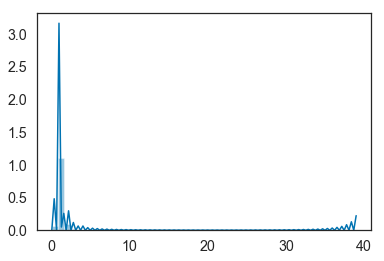

In [24]:
# potential BUG? is this correctly derived? confirm with colleague
# (nav events + search events) + 1 / related links clicked + 1
# add one to numerator and denominator to avoid undesirable characteristics
# not sure this has great utility as a proxy, seems volatile
df['Ratio_Nav_Search_to_Rel'] = (df['Content_Page_Nav_Event_Count'] + df.Content_Search_Event_Count + 1) / (df['Related Links Clicks row total'] + 1)
sns.distplot(df['Ratio_Nav_Search_to_Rel'].values);

This derived variable is problematic, should consider dropping it. Use counts of the numerator instead (as this could be modelled using generalised linear model), as related link clickedness is captured by the earlier metric.

## Tempoary df file in case of crash
### Save

In [5]:
# create temp file incase bootstrap below crashes
filepath = os.path.join(
    DATA_DIR, "metadata",
    "temp.csv.gz")



In [ ]:
# df.to_csv(filepath, sep="\t", compression="gzip", index=False)

## Read in temp df

In [6]:
df = pd.read_csv(filepath, sep ="\t", compression="gzip")


### Bayesian bootstrap

In [9]:
# For tutorial see...
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

# need to roll out the data, to resample from, deaggregate on one variable of interest
# we want to repeat each row's journey length by it's occurrences
# so more common journey lengths are more likely to be sampled

# r for ratio
a_r = np.repeat(df[df.ABVariant == "A"].Ratio_Nav_Search_to_Rel, df[df.ABVariant == "A"].Occurrences)
b_r = np.repeat(df[df.ABVariant == "B"].Ratio_Nav_Search_to_Rel, df[df.ABVariant == "B"].Occurrences)

# for reproducibility, set the seed within this context
with NumpyRNGContext(1337):
    a_bootstrap = bb.mean(a_r.values, n_replications=boot_reps)
    b_bootstrap = bb.mean(b_r.values, n_replications=boot_reps)
    
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 1.0346298304202886 
high ci: 1.0358759734897627
low ci: 1.0347711795949046 
high ci: 1.036027475636675


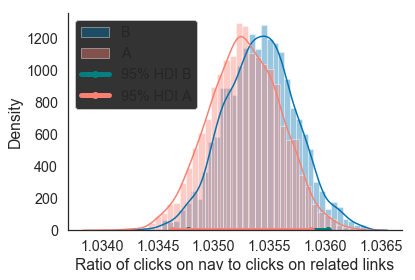

In [10]:
ax = sns.distplot(b_bootstrap, label='B')
ax.errorbar(x=[b_ci_low, b_ci_hi], y=[2, 2], linewidth=5, c='teal', marker='o', 
         label='95% HDI B')

ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.errorbar(x=[a_ci_low, a_ci_hi], y=[5, 5], linewidth=5, c='salmon', marker='o', 
         label='95% HDI A')

ax.set(xlabel='Ratio of clicks on nav to clicks on related links', ylabel='Density')
sns.despine()
plt.legend();

In [11]:
# calculate the posterior for the difference between A's and B's ratio
# ypa prefix is vestigial from blog post
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

# the mean of the posterior
print('mean:', ypa_diff.mean())

print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)

mean: 0.00013904231462012507
low ci: -0.0007133003395105586 
high ci: 0.001047501533098405


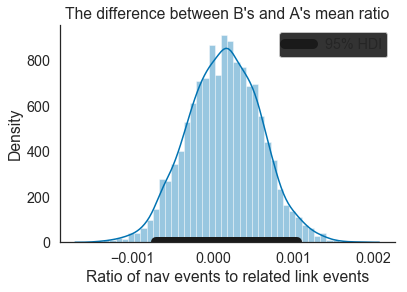

In [12]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Ratio of nav events to related link events', ylabel='Density', 
       title='The difference between B\'s and A\'s mean ratio')
sns.despine()
plt.legend();

In [13]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.6205

## proportion of journeys with a page sequence including content and related links only

There is no statistically significant difference in the proportion of journeys with a page sequence including content and related links only (including loops) between page variant A and page variant B

\begin{equation*}
\frac{\text{total number of journeys that only contain content pages and related links (i.e. no nav pages)}}{\text{total number of journeys}}
\end{equation*}

### Overall

In [14]:
# overall
df[df.Content_Page_Nav_Event_Count == 0].Occurrences.sum() / df.Occurrences.sum()

0.9669233329658382

### Frequentist statistics
#### Statistical significance

In [15]:
# using Bernoulli trial terminology where X (or x) is number of successes and n is number of trials
# total occurrences, both A and B
# assume non- A and B were dropped

# A & B
n = df.Occurrences.sum()
# prop of journeys with no nav events, occurrences summed for those rows gives X
p = df[df.Content_Page_Nav_Event_Count == 0].Occurrences.sum() / n

assert (p >= 0),"Prop less than zero!"
assert (p <= 1),"Prop greater than one!"

# A
# number of trials for page A
n_a = df[df.ABVariant == "A"].Occurrences.sum()
# number of successes (occurrences), for page A and no nav events
x_a = df[(df['ABVariant'] == 'A') & (df['Content_Page_Nav_Event_Count'] == 0)].Occurrences.sum()
# prop of journeys where one related link was clicked, on A
p_a = x_a / n_a

# B
# number of trials for page B
n_b = df[df.ABVariant == "B"].Occurrences.sum()
# number of successes for page B, and no nav events
x_b = df[(df['ABVariant'] == 'B') & (df['Content_Page_Nav_Event_Count'] == 0)].Occurrences.sum()
# prop of journeys where one related link was clicked, on B
p_b = x_b / n_b

assert (n == n_a + n_b), "Error in filtering by ABVariant!"

# validate assumptions
# The formula of z-statistic is valid only when sample size (n) is large enough.
# nAp, nAq, nBp and nBq should be ≥ 5.
# where p is probability of success (we can use current baseline)
# q = 1 - p

# tried a helper function here but it didn't work hence not DRY
assert (n_a*p) >= 5, "Assumptions for z prop test invalid!"
assert (n_a*(1-p)) >= 5, "Assumptions for z prop test invalid!"

assert (n_b*p) >= 5, "Assumptions for z prop test invalid!"
assert (n_b*(1-p)) >= 5, "Assumptions for z prop test invalid!"

In [16]:
# using statsmodels
# successes
count = np.array([x_a, x_b])
# number of trials
nobs = np.array([n_a, n_b])
# z prop test
z,p_value = proportions_ztest(count, nobs, value=0, alternative='two-sided')
print(' z-stat = {z} \n p-value = {p_value}'.format(z=z,p_value=p_value))

 z-stat = -0.38974264522801866 
 p-value = 0.6967268588441017


#### Practical significance - uplift

In [19]:
# function defined earlier in notebook

# Due to multiple testing we used the Bonferroni correction for alpha
ci_low,ci_upp = zconf_interval_two_samples(x_a, n_a,
                                           x_b, n_b, alpha = 0.01)
print(' 95% Confidence Interval = ( {0:.2f}% , {1:.2f}% )'
      .format(100*ci_low, 100*ci_upp))

 95% Confidence Interval = ( -0.06% , 0.08% )


## Average Journey Length (number of page views)
There is no statistically significant difference in the average page list length of journeys (including loops) between page variant A and page variant B.
### Bayesian bootstrap for non-parametric hypotheses

In [20]:
# http://savvastjortjoglou.com/nfl-bayesian-bootstrap.html

In [21]:
# let's use mean journey length (could probably model parametrically but we use it for demonstration here)
# some journeys have length 500 and should probably be removed as they are liekely bots or other weirdness

In [23]:
# need to roll out the data, deaggregate on one variable of interest
# we want to repeat each row's journey length by it's occurrences
# so more common journey lengths are more likely to be sampled
print(df['Page_List_Length'].head())
print(df['Occurrences'].head())

np.repeat(df['Page_List_Length'].head(), df['Occurrences'].head())


0    12
1    31
2     2
3     3
4    10
Name: Page_List_Length, dtype: int64
0    1
1    1
2    2
3    1
4    1
Name: Occurrences, dtype: int64


0    12
1    31
2     2
2     2
3     3
4    10
Name: Page_List_Length, dtype: int64

In [24]:
a_len = np.repeat(df[df.ABVariant == "A"].Page_List_Length, df[df.ABVariant == "A"].Occurrences)
a_len.values

b_len = np.repeat(df[df.ABVariant == "B"].Page_List_Length, df[df.ABVariant == "B"].Occurrences)
b_len.values

array([11, 16,  6, ...,  2,  3,  1])

In [25]:
help(bb.mean)

Help on function mean in module bayesian_bootstrap.bootstrap:

mean(X, n_replications)
    Simulate the posterior distribution of the mean.
    
    Parameter X: The observed data (array like)
    
    Parameter n_replications: The number of bootstrap replications to perform (positive integer)
    
    Returns: Samples from the posterior



In [26]:
# for reproducibility, set the seed within this context
with NumpyRNGContext(1337):
    a_bootstrap = bb.mean(a_len.values, n_replications=boot_reps)
    b_bootstrap = bb.mean(b_len.values, n_replications=boot_reps)

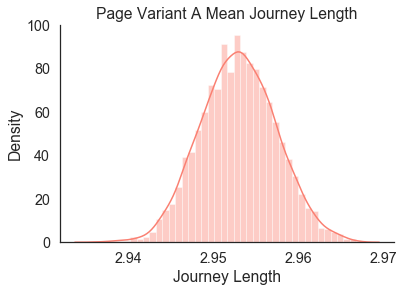

In [27]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine();

In [28]:
# Calculate a 95% HDI
a_ci_low, a_ci_hi = bb.highest_density_interval(a_bootstrap)
print('low ci:', a_ci_low, '\nhigh ci:', a_ci_hi)

low ci: 2.944496837436394 
high ci: 2.9617327071878643


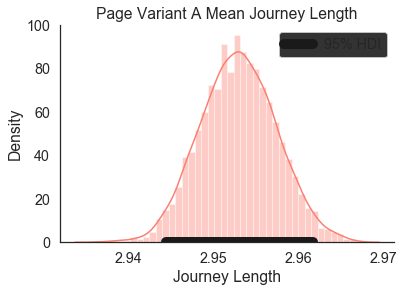

In [29]:
ax = sns.distplot(a_bootstrap, color='salmon')
ax.plot([a_ci_low, a_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant A Mean Journey Length')
sns.despine()
plt.legend();

In [30]:
# Calculate a 95% HDI
b_ci_low, b_ci_hi = bb.highest_density_interval(b_bootstrap)
print('low ci:', b_ci_low, '\nhigh ci:', b_ci_hi)

low ci: 2.9432618250419242 
high ci: 2.960736430124203


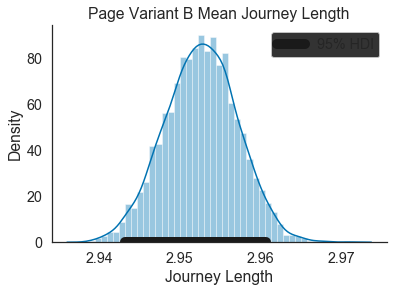

In [31]:
ax = sns.distplot(b_bootstrap)
ax.plot([b_ci_low, b_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', title='Page Variant B Mean Journey Length')
sns.despine()
plt.legend();

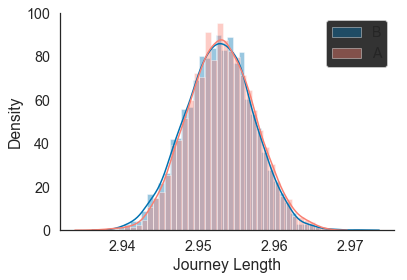

In [32]:
ax = sns.distplot(b_bootstrap, label='B')
ax = sns.distplot(a_bootstrap, label='A', ax=ax, color='salmon')
ax.set(xlabel='Journey Length', ylabel='Density')
sns.despine()
plt.legend();

We can also measure the uncertainty in the difference between the Page Variants's Journey Length by subtracting their posteriors.



In [33]:
# calculate the posterior for the difference between A's and B's YPA
ypa_diff = np.array(b_bootstrap) - np.array(a_bootstrap)
# get the hdi
ypa_diff_ci_low, ypa_diff_ci_hi = bb.highest_density_interval(ypa_diff)

In [34]:
# the mean of the posterior
ypa_diff.mean()

-0.0003399336458193403

In [35]:
print('low ci:', ypa_diff_ci_low, '\nhigh ci:', ypa_diff_ci_hi)


low ci: -0.012141617649469971 
high ci: 0.012394960510099917


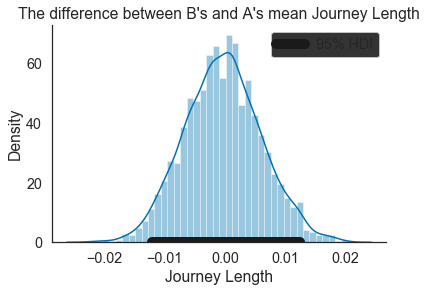

In [36]:
ax = sns.distplot(ypa_diff)
ax.plot([ypa_diff_ci_low, ypa_diff_ci_hi], [0, 0], linewidth=10, c='k', marker='o', 
         label='95% HDI')
ax.set(xlabel='Journey Length', ylabel='Density', 
       title='The difference between B\'s and A\'s mean Journey Length')
sns.despine()
plt.legend();

We can actually calculate the probability that B's mean Journey Length was greater than A's mean Journey Length by measuring the proportion of values greater than 0 in the above distribution.

In [37]:
# We count the number of values greater than 0 and divide by the total number
# of observations
# which returns us the the proportion of values in the distribution that are
# greater than 0, could act a bit like a p-value
(ypa_diff > 0).sum() / ypa_diff.shape[0]

0.483